## Astronomy with Python

Author: Simone Garrappa

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

import astropy.units as u
from astropy.constants import G, h, k_B
from astropy.visualization import quantity_support
from astropy.coordinates import SkyCoord
from IPython.display import Image
from astropy.table import Table


from urllib.parse import urlencode
from urllib.request import urlretrieve

### Coordinates and units

Astropy can handle sky coordinates in several coordinate systems. Sky positions can be set manually or looking for object names in catalogs (i.e. stars,galaxies...).
Let's try to get the positions of the two brightest stars in the Gemini constellation:

In [ ]:
castor_coor = SkyCoord.from_name('Castor')
pollux_coor = SkyCoord.from_name('Pollux')

we can calculate the angular distance between the two selected stars with:

In [ ]:
dist = castor_coor.separation(pollux_coor)
print("Angular distance: {0:.3g}".format(dist.to(u.deg)))

We have computed the angular separation in the sky between the two stars, but we could also calculate the 3D distance between the objects when their distance from the observer is known.

In [ ]:
c1 = SkyCoord('6h33m31.5s', '-54d41m23s', distance=70*u.kpc, frame='icrs')
c2 = SkyCoord('1h22m14.8s', '-63d49m47s', distance=80*u.kpc, frame='icrs')
sep = c1.separation_3d(c2)
sep

In [ ]:
c1 = c1.transform_to('galactic')


We can move to a different coordinates frame of reference, for example we can convert the coordinates of Pollux to the Galactic frame:


In [ ]:
pollux_coor.transform_to('galactic')

Many coordinate frames and equinoxes are available by default in Astropy:

ICRS

FK5

FK4

FK4NoETerms

Galactic

Galactocentric

Supergalactic

AltAz

GCRS

CIRS

ITRS

HCRS

PrecessedGeocentric

GeocentricTrueEcliptic

BarycentricTrueEcliptic

HeliocentricTrueEcliptic

SkyOffsetFrame

GalacticLSR

LSR

BaseEclipticFrame

BaseRADecFrame

There are several methods for each class, and they can be explored with 'dir()':

In [ ]:
#dir(SkyCoord)

In [ ]:
# set the cutout size we want
im_size = 30*u.arcmin # get a 12 arcmin square
im_pixels = 1024
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=obj_coord.ra.deg,
                              dec=obj_coord.dec.deg,
                              width=im_pixels, height=im_pixels,
                              scale=im_size.to(u.arcsec).value/im_pixels))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
image_name = 'Obj_SDSS_cutout.jpg'
urlretrieve(url, image_name )
Image(image_name)

### Exercise break 1 (10 min)

Find the coordinates of the two Galaxies M81 and M82, compute their angular distance and give the result in degreees, arcmin and arcseconds.
In which constellation are the two galaxies located? Try to find it out from the methods of the SkyCoord class!



## File I/O, working with catalogs

We explore a typical user-case in astronomy, parsing information from the commonly adopted FITS files. We use the Fourth Fermi-LAT Source Catalog (4FGL) that uses 8 years of Fermi-LAT observations.

In [ ]:
import astropy.io.fits as pyfits

hdu_list = pyfits.open('gll_psc_v21.fit')

We could investigate the main structure of the FITS file with a simple method and find the table we are interested in:

In [ ]:
hdu_list.info()

We are interested in the point source catalog, so we explore the table looking at the description of the different columns

In [ ]:
#print(hdu_list[1].columns)


In [ ]:
point_src = Table(hdu_list[1].data)



In [ ]:
point_src.colnames

Let's plot in the sky the positions of the brightest sources detected by Fermi-LAT

In [ ]:
flux_hist = plt.hist(point_src['Flux1000'], bins='auto')
plt.semilogx()
plt.semilogy()
plt.xlabel(r'Flux1000 (ph cm$^{-2}$ s$^{-1}$)')
plt.ylabel('Number of sources')


We only select sources with a value of "Flux1000" above 6$\times$10$^{-8}$ ph cm$^{-2}$ s$^{-1}$

In [ ]:
#define empty lists to be filled with our selected objects
src_lon = []
src_lat = []
src_name = []

for i, item in enumerate(point_src['ASSOC1']):
    if point_src['Flux1000'][i] < 6e-8: continue
    src_name.append(item)
    src_lon.append(point_src['GLON'][i])
    src_lat.append(point_src['GLAT'][i])
    


In [ ]:
src_lon

In [ ]:
fig = plt.figure(figsize=(10, 6))
font = {'family': 'serif',  'color':'black', 'weight': 'normal', 'size': 16.} 
ax = fig.add_subplot(111, projection="aitoff")

n_src = len(src_name)
src_coord = SkyCoord(l = src_lon*u.degree, b = src_lat*u.degree, frame="galactic")


lon_src, lat_src = src_coord.l, src_coord.b
lon_src = -lon_src.wrap_at(180*u.degree) #  flip it and fold it so that it looks normal

color=iter(cm.rainbow(np.linspace(0,1,n_src)))

for name, lon, lat in zip(src_name, lon_src, lat_src):
    ax.plot(lon.radian, lat.radian, label = name, marker = 'o', markersize=10, ls='', color=next(color))

ax.grid(True)
ax.set_xticklabels(['150$^\circ$','120$^\circ$','90$^\circ$','60$^\circ$','30$^\circ$','0$^\circ$',
                    '-30$^\circ$','-60$^\circ$','-90$^\circ$','-210$^\circ$','-270$^\circ$'])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), numpoints=1, ncol=3, fancybox=True, shadow=True)
fig.tight_layout()
plt.show()

## Observations planning

In [ ]:
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz

M101 = SkyCoord.from_name('M101') 
print(M101)

In [ ]:
# define Berlin Location
#Berlin = EarthLocation(lat=52.52*u.deg, lon=13.41*u.deg, height=34*u.m)
Berlin = EarthLocation.of_address('Treptower Park, Berlin')


# We have to set an offset of 2 hours for the Berlin time zone, defined as Central European Summer Time (CEST)
utcoffset = +2*u.hour 
time = Time('2020-5-26 23:00:00') - utcoffset
# M101 coordinates in Berlin Horizontal Coordinate System
M101_altaz = M101.transform_to(AltAz(obstime=time,location=Berlin))  
"M101's Altitude = {0.alt:.2}".format(M101_altaz)

In [ ]:
from astropy.coordinates import get_sun
midnight = Time('2020-05-27 00:00:00') - utcoffset
# create an array of times from 12h before to 12 after midnight
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
times = midnight + delta_midnight
# Berlin Horizontal Coordinate system
altazframe = AltAz(obstime=times, location=Berlin)
# Sun's position in it
sunaltazs = get_sun(times).transform_to(altazframe)
M101_altazs = M101.transform_to(altazframe)  

fig3 = plt.figure(figsize=(10, 6))
plt.plot(delta_midnight, sunaltazs.alt, color='y', label='Sun')  
# plot accounting fro the Azimuth
plt.scatter(delta_midnight, M101_altazs.alt, c=M101_altazs.az, label='M101', lw=0, s=8)  
# plot a gray band corresponding to dark time i.e. negative altitude of the sun
plt.fill_between(delta_midnight.to('hr').value, 0, 90, sunaltazs.alt < 0*u.deg, color='0.2', zorder=0)  
plt.colorbar().set_label('Azimuth [deg]')  
plt.legend(loc='upper left')  
plt.xlim(-12, 12)  
plt.xticks(np.arange(13)*2 -12)  
plt.ylim(0, 90)  
plt.xlabel('Hours from CEST Midnight')  
plt.ylabel('Altitude [deg]')  
plt.show()

In [ ]:
# set the cutout size we want
obj_coord = M101
im_size = 30*u.arcmin # get a 12 arcmin square
im_pixels = 1024
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=obj_coord.ra.deg,
                              dec=obj_coord.dec.deg,
                              width=im_pixels, height=im_pixels,
                              scale=im_size.to(u.arcsec).value/im_pixels))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
image_name = 'Obj_SDSS_cutout.jpg'
urlretrieve(url, image_name )
Image(image_name)

### Exercise break 3 (15 min)

Plan an observation for the Andromeda Galaxy M31 on September 22, 2020 from Rome (Italy) and from Sidney (Australia), and check also the Moon for that night!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [2]:
M101 = SkyCoord.from_name('M101') 


In [3]:
# define Berlin Location
#Berlin = EarthLocation(lat=52.52*u.deg, lon=13.41*u.deg, height=34*u.m)
Berlin = EarthLocation.of_address('Treptower Park, Berlin')


# We have to set an offset of 2 hours for the Berlin time zone, defined as Central European Summer Time (CEST)
utcoffset = +2*u.hour 
midnight = Time('2020-5-27 00:00:00') - utcoffset

In [5]:
# M101 coordinates in Berlin Horizontal Coordinate System
M101_altaz = M101.transform_to(AltAz(obstime=midnight,location=Berlin))  
"M101's Altitude = {0.alt:.2}".format(M101_altaz)



"M101's Altitude = 7.9e+01 deg"

In [ ]:
#midnight = Time('2020-05-26 00:00:00') - utcoffset
##delta_midnight = np.linspace(-2, 10, 100)*u.hour
#frame_May26night = AltAz(obstime=midnight+delta_midnight,
#                          location=Berlin)
#m101altazs_May26night = M101.transform_to(frame_May26night)

In [6]:
from astropy.coordinates import get_sun
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
times_ = midnight + delta_midnight
frame_ = AltAz(obstime=times_, location=Berlin)
sunaltazs_ = get_sun(times_).transform_to(frame_)

In [7]:
M101altazs_May26 = M101.transform_to(frame_)

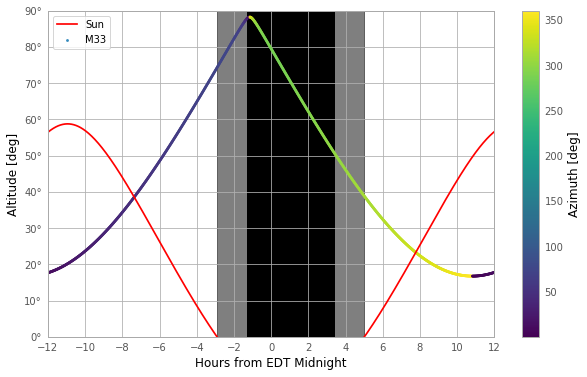

In [14]:
fig3 = plt.figure(figsize=(10, 6))
plt.plot(delta_midnight, sunaltazs_.alt, color='r', label='Sun')
plt.scatter(delta_midnight, M101altazs_May26.alt,
            c=M101altazs_May26.az, label='M33', lw=0, s=8,
            cmap='viridis')
plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,
                 sunaltazs_.alt < -0*u.deg, color='k',alpha = 0.5, zorder=0)
plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,
                 sunaltazs_.alt < -10*u.deg, color='k', zorder=0)
plt.colorbar().set_label('Azimuth [deg]')
plt.legend(loc='upper left')
plt.xlim(-12*u.hour, 12*u.hour)
plt.xticks((np.arange(13)*2-12)*u.hour)
plt.ylim(0*u.deg, 90*u.deg)
plt.xlabel('Hours from EDT Midnight')
plt.ylabel('Altitude [deg]')
plt.show()